## Campos involucrados

- direccion
- idzona
- ciudad
- provincia
- lat
- lng

## Objetivos

- Normalizar (provincia, ciudad, dirección)
- Agregar información (geometry)
- Métodos para graficar (cantidad+densidad)
- Método para definir si x publicación está en una geometry

- Agregar información externa (distrito electoral, etc.)


In [42]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [43]:
#importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
#importo las funciones para graficar
%run "../../utils/graphs.ipynb"

In [44]:
pais = geopandas.read_file("./MEX_adm/MEX_adm0.shp")
estados = geopandas.read_file("./MEX_adm/MEX_adm1.shp")
municipios = geopandas.read_file("./MEX_adm/MEX_adm2.shp")
ciudades = geopandas.read_file("./México_Centros_Urbanos/México_Centros_Urbanos.shp")
mexico_polygon = pais.iloc[0]["geometry"]

In [74]:
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
df["tiene_gps"] = ~ (df["lat"].isna() & df["lng"].isna())
crear_punto = lambda x: Point(x["lng"],x["lat"]) if x["tiene_gps"] else None
df["coord"] = df.apply(crear_punto, axis=1)

In [46]:
def esta_en_mexico(point: Point) -> bool:
    """ 
        Recibe un punto (lat,lng) y devuelve (muy aproximadamente) True si está dentro de Mexico, False si no.
        Hacerlo con ```df["coord"].map(lambda x: mexico_polygon.contains(x))``` sería muy lento.
    """
    MEX_MIN_LNG, MEX_MAX_LNG = (-120, -85)
    MEX_MIN_LAT, MEX_MAX_LAT = (14,33)
    return (MEX_MIN_LNG < point.x < MEX_MAX_LNG) and (MEX_MIN_LAT < point.y < MEX_MAX_LAT)

In [47]:
df["en_mexico"] = df.loc[df["tiene_gps"]]["coord"].map(esta_en_mexico)

In [48]:
df["en_mexico"].value_counts()

True     115871
False       641
Name: en_mexico, dtype: int64

In [49]:
geoDF = geopandas.GeoDataFrame(df.loc[df["tiene_gps"] & df["en_mexico"]], geometry="coord")

In [50]:
def dibujar_mexico(puntos):
    grafico = pais.plot(figsize=(18,9))
    estados.plot(ax=grafico, color="white")
#     municipios.plot(ax=grafico, color="white")
    # ciudades.plot(ax=grafico, color="yellow")
    puntos.plot(ax=grafico, color="green")

In [51]:
def fix_provincias(df, provincias) -> bool:
    # le cambio los nombres a las siguientes provincias, para que coincidan con mi info geografica 
    provincias_mapper = {
        "Baja California Norte": "Baja California",
        "Edo. de México": "México",
        "San luis Potosí": "San Luis Potosí"
    }
    df["estado"] = df["provincia"].map(lambda x: provincias_mapper.get(x, x))
    return set(validos["provincia"].dropna().unique()) == set(provincias["NAME_1"]) #verifico

In [52]:
fix_provincias(geoDF, estados)

NameError: name 'validos' is not defined

In [53]:
def buscar_provincia(punto: Point, provincias):
    """
        Devuelve en qué provincia de mexico se encuentra el punto.
    """
#     if not punto: return None
    for provincia, geometry in provincias[["NAME_1","geometry"]].values:
        if geometry.contains(punto): return provincia

# agrego las provincias faltantes
geoDF.loc[geoDF["estado"].isna(), "estado"] = geoDF.loc[geoDF["estado"].isna()]["coord"].map(lambda x: buscar_provincia(x, estados))

In [54]:
publicaciones_por_estado = geoDF.loc[~geoDF["estado"].isna()].groupby(["estado"]).agg({"estado":"count"})

In [55]:
def choropleth_estados(estados, serie, nombre, titulo=""):
    estados[nombre] = estados["NAME_1"].map(serie)
    plot = estados.plot(column=nombre, legend=True, figsize=(24,8))    
    plot.set_title(titulo)
    return plot

ImportError: The descartes package is required for plotting polygons in geopandas.

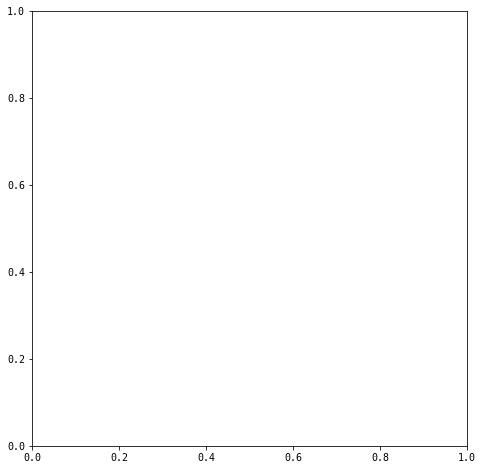

In [56]:
plot = choropleth_estados(estados, publicaciones_por_estado["estado"], "publicaciones", "Cantidad de publicaciones por estado")

# Presento un análisis del valor del metro cuadrado en relacion al clima

In [93]:
#Primero realizo un calculo del promedio del valor del metro cuadrado por 
por_ciudad=df.groupby("ciudad").agg({"metrostotales":"sum"})
por_ciudad["precios"] = df.groupby("ciudad").agg({"precio":"sum"})
por_ciudad["valormetrocuadrado"] = por_ciudad["precios"] / por_ciudad["metrostotales"]


### Limpio el dataset de valores nulos en metrostotales y/o precios

In [94]:
por_ciudad=por_ciudad.loc[(por_ciudad.metrostotales != 0.0)]
por_ciudad=por_ciudad.loc[(por_ciudad.precios != 0.0)]

# Busco las ciudades extremo, la mas cara y la mas barata

In [109]:
por_ciudad = por_ciudad.sort_values("valormetrocuadrado")
print(por_ciudad)
ciudad_mas_barata = por_ciudad["valormetrocuadrado"].min()
ciudad_mas_cara = por_ciudad["valormetrocuadrado"].max()
amplitud = ciudad_mas_cara - ciudad_mas_barata
print(amplitud)#ver como sacar el nombre de la ciudad

                         metrostotales     precios  valormetrocuadrado
ciudad                                                                
Santa Isabel Xiloxoxtla          435.0    313200.0        7.200000e+02
Ahuazotepec                      400.0    320000.0        8.000000e+02
Mazatepec                        400.0    350000.0        8.750000e+02
Villa Purificación               376.0    376000.0        1.000000e+03
Tecali de Herrera                336.0    350000.0        1.041667e+03
...                                ...         ...                 ...
Ucú                               26.0   8500000.0        3.269231e+05
Tolimán                           35.0  12000000.0        3.428571e+05
Atempan                           40.0  16112121.0        4.028030e+05
Motul                             17.0  10950000.0        6.441176e+05
Villa Victoria                    26.0  27650000.0        1.063462e+06

[705 rows x 3 columns]
1062741.5384615385


In [111]:
top_20_ciudades_mas_caras = por_ciudad.tail(20)
top_20_ciudades_mas_caras 

,metrostotales,precios,valormetrocuadrado
ciudad,,,
Río Lagartos,89.0,7100000.0,7.977528e+04
Cacalchén,70.0,5600000.0,8.000000e+04
Otumba,458.0,36810000.0,8.037118e+04
Jilotzingo,1180.0,100184000.0,8.490169e+04
Izamal,33.0,3000000.0,9.090909e+04
Jerécuaro,90.0,8430000.0,9.366667e+04
Apaseo el Alto,120.0,11728000.0,9.773333e+04
Batopilas,120.0,12000000.0,1.000000e+05
Palenque,118.0,12582834.0,1.066342e+05


In [112]:
top_20_ciudades_mas_baratas = por_ciudad.head(20)
top_20_ciudades_mas_baratas

,metrostotales,precios,valormetrocuadrado
ciudad,,,
Santa Isabel Xiloxoxtla,435.0,313200.0,720.000000
Ahuazotepec,400.0,320000.0,800.000000
Mazatepec,400.0,350000.0,875.000000
Villa Purificación,376.0,376000.0,1000.000000
Tecali de Herrera,336.0,350000.0,1041.666667
Apazapan,383.0,400000.0,1044.386423
Cansahcab,300.0,334000.0,1113.333333
Villa de Tezontepec,400.0,450000.0,1125.000000
Sabinas,300.0,354050.0,1180.166667
